# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [2]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

기본 전처리 할것들

In [3]:
# 'Workorder_AutoClave' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder'] = train_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)
test_data['Workorder'] = test_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

In [4]:
# Dispenser_num 값에 따라 새로운 변수 생성
train_data['Dispenser_1'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
train_data['Dispenser_2'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

test_data['Dispenser_1'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
test_data['Dispenser_2'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

# 불필요한 변수 제거
train_data.drop(['Dispenser_num'], axis=1, inplace=True)
test_data.drop(['Dispenser_num'], axis=1, inplace=True)

In [5]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

In [6]:
# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

In [7]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_receip_no_collect_result(df):
    df['Receip_No_Collect_Result'] = df.apply(
        lambda row: row['Receip No Collect Result_Dam'] 
                    if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_receip_no_collect_result(train_data)
create_receip_no_collect_result(test_data)

In [8]:
# 제거할 변수 목록
columns_to_drop = [
    'Receip No Collect Result_Dam',
    'Receip No Collect Result_Fill1',
    'Receip No Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [9]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [10]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [11]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam'] 
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [12]:
# 제거할 변수 목록
columns_to_drop = [
    'Production Qty Collect Result_Dam',
    'Production Qty Collect Result_Fill1',
    'Production Qty Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [13]:
# "Chamber Temp. Judge Value_AutoClave" 변수의 값을 기준으로 파생 변수 생성 함수
def create_judge_value_binary(df):
    df['Chamber_Temp_OKNG_AutoClave'] = df['Chamber Temp. Judge Value_AutoClave'].apply(
        lambda x: 1 if x == 'OK' else 0
    )

# 함수 적용
create_judge_value_binary(train_data)
create_judge_value_binary(test_data)

In [14]:
# 'Judge Value'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Judge Value').columns

print("\n Judge Value 포함 변수>")
for col in Process_Desc_col:
    print(col)


 Judge Value 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2


In [15]:
# 5개의 변수 목록
judge_value_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
]

# 파생 변수 생성 함수
def create_judge_value_feature(df):
    df['Judge_Value_OK'] = df[judge_value_columns].apply(
        lambda row: 1 if any(row == 'OK') else 0, 
        axis=1
    )

# 함수 적용
create_judge_value_feature(train_data)
create_judge_value_feature(test_data)

In [16]:
# 제거할 변수 목록
columns_to_drop = [
    'Chamber Temp. Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [17]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 108 entries, Model.Suffix to Judge_Value_OK
dtypes: float64(56), int64(49), object(3)
memory usage: 33.4+ MB


In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 109 entries, Set ID to Judge_Value_OK
dtypes: float64(86), int64(20), object(3)
memory usage: 14.4+ MB


---

반복적으로 쓰는 툴 함수화

In [20]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

In [21]:
def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [22]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [23]:
def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ratio_boxplot(data, time_ratio_column, target_column='target'):
    # 그래프 스타일 설정
    sns.set(style="whitegrid")

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=time_ratio_column, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{time_ratio_column} vs {target_column}')
    plt.xlabel(time_ratio_column)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

# 함수 호출 예제
#plot_time_ratio_vs_target(train_data, 'time_ratio_Dam')

---

In [25]:
train_data.columns.to_list()

['Model.Suffix',
 'Workorder',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Resul

### 1. CURE

In [26]:
# 'CURE'와 '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
CURE END POSITION X Collect Result_Fill2
CURE END POSITION Z Collect Result_Fill2
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE START POSITION X Collect Result_Fill2
CURE START POSITION Z Collect Result_Fill2


In [27]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
# 'CURE END POSITION X Collect Result_Dam'
, 'CURE END POSITION Θ Collect Result_Dam'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE START POSITION X Collect Result_Dam'
, 'CURE START POSITION Θ Collect Result_Dam'
# , 'CURE END POSITION X Collect Result_Fill2'
# , 'CURE END POSITION Z Collect Result_Fill2'
# , 'CURE SPEED Collect Result_Fill2'
# , 'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE START POSITION X Collect Result_Fill2'
# , 'CURE START POSITION Z Collect Result_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE END POSITION Θ Collect Result_Dam, CURE START POSITION Θ Collect Result_Dam

              group  'AdNormal' count     ratio  Total
0  (0, 0, -90, -90)                19  1.000000     19
1    (0, 0, 90, 90)                15  1.000000     15
2    (0, 1, 90, 90)               850  0.054977  15461
3  (1, 0, -90, -90)              1466  0.058614  25011


dispenser 종류에 따라 POSITION Θ 값이 따라감  
-> drop

In [28]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [29]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE END POSITION X Collect Result_Fill2
CURE END POSITION Z Collect Result_Fill2
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE START POSITION X Collect Result_Fill2
CURE START POSITION Z Collect Result_Fill2


In [30]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
, 'CURE END POSITION X Collect Result_Dam'
, 'CURE END POSITION Z Collect Result_Dam'
# , 'CURE SPEED Collect Result_Dam'
, 'CURE START POSITION X Collect Result_Dam'
# , 'CURE END POSITION X Collect Result_Fill2'
# , 'CURE END POSITION Z Collect Result_Fill2'
# , 'CURE SPEED Collect Result_Fill2'
# , 'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE START POSITION X Collect Result_Fill2'
# , 'CURE START POSITION Z Collect Result_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE END POSITION X Collect Result_Dam, CURE END POSITION Z Collect Result_Dam, CURE START POSITION X Collect Result_Dam

                     group  'AdNormal' count     ratio  Total
0   (0, 0, 240, 2.5, 1030)                19  1.000000     19
1  (0, 0, 1000, 12.5, 280)                15  1.000000     15
2  (0, 1, 1000, 12.5, 280)               850  0.054977  15461
3   (1, 0, 240, 2.5, 1030)              1466  0.058614  25011


좌표값을 통해 좌표간의 거리를 계산

In [31]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [32]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Fill2'
start_z_col = 'CURE START POSITION Z Collect Result_Fill2'
end_x_col = 'CURE END POSITION X Collect Result_Fill2'
end_z_col = 'CURE END POSITION Z Collect Result_Fill2'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

test_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

In [33]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE START POSITION X Collect Result_Dam'
    , 'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'

    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [34]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2


In [35]:
summarize_group(train_data, [
# 'Dispenser_1'
# , 'Dispenser_2'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE SPEED Collect Result_Fill2'
 'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE_DISTANCE_Dam'
# , 'CURE_DISTANCE_Fill2'
])

Grouped by: CURE STANDBY POSITION Z Collect Result_Fill2

   group  'AdNormal' count     ratio  Total
0  (22,)                34  0.072495    469
1  (23,)                22  0.107843    204
2  (32,)               421  0.085866   4903
3  (33,)              1873  0.053622  34930


'CURE STANDBY POSITION Z Collect Result_Fill2' 변수의 유의미함을 찾을수 x  
다른 변수와 연결된만한것도 찾지 못함 -> drop

In [36]:
# 제거할 변수 목록
columns_to_drop = ['CURE STANDBY POSITION Z Collect Result_Fill2']

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [37]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2


In [38]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE SPEED Collect Result_Fill2'
, 'CURE_DISTANCE_Dam'
, 'CURE_DISTANCE_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE_DISTANCE_Dam, CURE_DISTANCE_Fill2

                                          group  'AdNormal' count     ratio  \
0              (0, 0, 720.3061848963953, 780.0)                15  1.000000   
1               (0, 0, 790.607993888248, 780.0)                19  1.000000   
2              (0, 1, 720.3061848963953, 780.0)               827  0.054645   
3  (0, 1, 720.3061848963953, 780.0006410253776)                23  0.070552   
4  (0, 1, 720.3061848963953, 780.0775602464155)                 0  0.000000   
5               (1, 0, 790.607993888248, 780.0)              1129  0.054418   
6   (1, 0, 790.607993888248, 780.0006410253776)               286  0.077591   
7   (1, 0, 790.607993888248, 780.0640999302557)                51  0.088235   

   Total  
0     15  
1     19  
2  15134  
3    326  
4      1  
5  20747  
6   3686  
7    578  


거리의 차이에 따라 ratio 값 변화 크지 x

In [39]:
# 거리 / 속도 -> 시간 파생 변수 생성
train_data['CURE_Time_Dam']  = train_data['CURE_DISTANCE_Dam'] / train_data['CURE SPEED Collect Result_Dam']
test_data['CURE_Time_Dam']  = test_data['CURE_DISTANCE_Dam'] / test_data['CURE SPEED Collect Result_Dam']

train_data['CURE_Time_Fill2']  = train_data['CURE_DISTANCE_Fill2'] / train_data['CURE SPEED Collect Result_Fill2']
test_data['CURE_Time_Fill2']  = test_data['CURE_DISTANCE_Fill2'] / test_data['CURE SPEED Collect Result_Fill2']

In [40]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2
CURE_Time_Dam
CURE_Time_Fill2


In [41]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
    , 'CURE_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [42]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE_Time_Dam
CURE_Time_Fill2


### 2. HEAD NORMAL COORDINATE

In [43]:
# 'HEAD NORMAL COORDINATE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL COORDINATE').columns

print("\n HEAD NORMAL COORDINATE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL COORDINATE 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Coll

In [44]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [45]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    # data['HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [46]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [47]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [48]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    # data['HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [49]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [50]:
import numpy as np

# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [51]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [52]:
# 'HEAD NORMAL'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL').columns

print("\n HEAD NORMAL 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL 포함 변수>
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2


In [53]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'
    # , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'
    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [54]:
# 'HEAD NORMAL'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL').columns

print("\n HEAD NORMAL 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL 포함 변수>
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2


### 3. RESIN(처리x)

In [55]:
# 'RESIN' 또는 'Dispense Volume'을 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(regex='RESIN|Dispense Volume').columns

print("\n'RESIN' 또는 'Dispense Volume' 포함 변수>")
for col in Process_Desc_col:
    print(col)


'RESIN' 또는 'Dispense Volume' 포함 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1


In [56]:
summarize_group(train_data, [
# 'Dispenser_1'
# , 'Dispenser_2'
# , 'DISCHARGED SPEED OF RESIN Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
 'Dispense Volume(Stage1) Collect Result_Dam'
, 'Dispense Volume(Stage2) Collect Result_Dam'
, 'Dispense Volume(Stage3) Collect Result_Dam'
# , 'DISCHARGED SPEED OF RESIN Collect Result_Fill1'
# , 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'
# , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'
# , 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'
# , 'Dispense Volume(Stage1) Collect Result_Fill1'
# , 'Dispense Volume(Stage2) Collect Result_Fill1'
# , 'Dispense Volume(Stage3) Collect Result_Fill1'
])

Grouped by: Dispense Volume(Stage1) Collect Result_Dam, Dispense Volume(Stage2) Collect Result_Dam, Dispense Volume(Stage3) Collect Result_Dam

                  group  'AdNormal' count     ratio  Total
0    (0.67, 0.26, 1.49)                 8  0.075472    106
1    (0.67, 0.27, 1.49)               277  0.086293   3210
2    (0.67, 0.28, 1.49)                 0  0.000000      2
3    (0.67, 0.33, 1.49)                51  0.099415    513
4    (0.67, 0.34, 1.49)               467  0.082276   5676
..                  ...               ...       ...    ...
155  (1.63, 0.92, 1.49)                41  0.048810    840
156  (1.63, 0.93, 1.49)                46  0.080844    569
157  (1.63, 0.94, 1.49)                34  0.068273    498
158  (2.34, 0.71, 1.49)                 0  0.000000      1
159  (2.34, 0.72, 1.49)                 0  0.000000      3

[160 rows x 4 columns]


In [57]:
# # 파생 변수 생성 함수
# def create_time_speed_product(df):
#     stages = ['Stage1', 'Stage2', 'Stage3']
#     for stage in stages:
#         time_col = f'DISCHARGED TIME OF RESIN({stage}) Collect Result_Dam'
#         speed_col = 'DISCHARGED SPEED OF RESIN Collect Result_Dam'
#         new_col_name = f'RESIN Time_x_Speed_{stage}_Dam'
#         df[new_col_name] = df[time_col] * df[speed_col]

# # 함수 적용
# create_time_speed_product(train_data)
# create_time_speed_product(test_data)

In [58]:
# summarize_group(train_data, [
# 'Dispenser_1'
# , 'Dispenser_2'
# , 'DISCHARGED SPEED OF RESIN Collect Result_Dam'

# ])

In [59]:
# # 파생 변수 생성 함수
# def create_volume_time_ratio(df):
#     stages = ['Stage1', 'Stage2', 'Stage3']
#     for stage in stages:
#         time_col = f'DISCHARGED TIME OF RESIN({stage}) Collect Result_Dam'
#         volume_col = f'Dispense Volume({stage}) Collect Result_Dam'
#         new_col_name = f'RESIN Volume_Time_Ratio_{stage}_Dam'
#         df[new_col_name] = df[volume_col] / df[time_col]

# # 함수 적용
# create_volume_time_ratio(train_data)
# create_volume_time_ratio(test_data)

In [60]:
# # 출력 옵션을 설정
# pd.set_option('display.max_rows', None)


# # 출력 옵션을 원래대로
# pd.reset_option('display.max_rows')

In [61]:
# summarize_group(train_data, [
# 'Dispenser_1'
# , 'Dispenser_2'
# , 'DISCHARGED SPEED OF RESIN Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'
# , 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
# , 'Dispense Volume(Stage1) Collect Result_Dam'
# , 'Dispense Volume(Stage2) Collect Result_Dam'
# , 'Dispense Volume(Stage3) Collect Result_Dam'
# # , 'DISCHARGED SPEED OF RESIN Collect Result_Fill1'
# # , 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'
# # , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'
# # , 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'
# # , 'Dispense Volume(Stage1) Collect Result_Fill1'
# # , 'Dispense Volume(Stage2) Collect Result_Fill1'
# # , 'Dispense Volume(Stage3) Collect Result_Fill1'
# # , 'RESIN Time_x_Speed_Stage1_Dam'
# # , 'RESIN Time_x_Speed_Stage2_Dam'
# # , 'RESIN Time_x_Speed_Stage3_Dam'
# #  'RESIN Volume_Time_Ratio_Stage1_Dam'
# # , 'RESIN Volume_Time_Ratio_Stage2_Dam'
# # , 'RESIN Volume_Time_Ratio_Stage3_Dam'
# ])

In [62]:
# # 'RESIN' 또는 'Dispense Volume'을 포함하는 열 이름 필터링
# Process_Desc_col = train_data.filter(regex='RESIN|Dispense Volume').columns

# print("\n'RESIN' 또는 'Dispense Volume' 포함 변수>")
# for col in Process_Desc_col:
#     print(col)

### 4. Distance Speed Collect Result_Dam

Dam 공정의 Circle, Line 길이 변수들 처리

In [63]:
# 'Distance Speed Collect Result_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Distance Speed Collect Result_Dam').columns

print("\n Distance Speed Collect Result_Dam 포함 변수>")
for col in Process_Desc_col:
    print(col)


 Distance Speed Collect Result_Dam 포함 변수>
Stage1 Circle1 Distance Speed Collect Result_Dam
Stage1 Circle2 Distance Speed Collect Result_Dam
Stage1 Circle3 Distance Speed Collect Result_Dam
Stage1 Circle4 Distance Speed Collect Result_Dam
Stage1 Line1 Distance Speed Collect Result_Dam
Stage1 Line2 Distance Speed Collect Result_Dam
Stage1 Line3 Distance Speed Collect Result_Dam
Stage1 Line4 Distance Speed Collect Result_Dam
Stage2 Circle1 Distance Speed Collect Result_Dam
Stage2 Circle2 Distance Speed Collect Result_Dam
Stage2 Circle3 Distance Speed Collect Result_Dam
Stage2 Circle4 Distance Speed Collect Result_Dam
Stage2 Line1 Distance Speed Collect Result_Dam
Stage2 Line2 Distance Speed Collect Result_Dam
Stage2 Line3 Distance Speed Collect Result_Dam
Stage2 Line4 Distance Speed Collect Result_Dam
Stage3 Circle1 Distance Speed Collect Result_Dam
Stage3 Circle2 Distance Speed Collect Result_Dam
Stage3 Circle3 Distance Speed Collect Result_Dam
Stage3 Circle4 Distance Speed Collect Resu

Stage 별 Speed 값들의 평균 계산

In [64]:
def add_stage_totals(data, stages, suffix='_Distance_Speed_avg_Dam'):
    for stage in stages:
        stage_cols = data.filter(like=stage).columns
        data[f'{stage}{suffix}'] = data[stage_cols].sum(axis=1) / 8

stages = ['Stage1', 'Stage2', 'Stage3']

# train_data에 대해 파생변수 추가
add_stage_totals(train_data, stages)

# test_data에 대해 파생변수 추가
add_stage_totals(test_data, stages)

In [65]:
# 제거할 변수 목록
columns_to_drop = [
'Stage1 Circle1 Distance Speed Collect Result_Dam'
, 'Stage1 Circle2 Distance Speed Collect Result_Dam'
, 'Stage1 Circle3 Distance Speed Collect Result_Dam'
, 'Stage1 Circle4 Distance Speed Collect Result_Dam'
, 'Stage1 Line1 Distance Speed Collect Result_Dam'
, 'Stage1 Line2 Distance Speed Collect Result_Dam'
, 'Stage1 Line3 Distance Speed Collect Result_Dam'
, 'Stage1 Line4 Distance Speed Collect Result_Dam'
, 'Stage2 Circle1 Distance Speed Collect Result_Dam'
, 'Stage2 Circle2 Distance Speed Collect Result_Dam'
, 'Stage2 Circle3 Distance Speed Collect Result_Dam'
, 'Stage2 Circle4 Distance Speed Collect Result_Dam'
, 'Stage2 Line1 Distance Speed Collect Result_Dam'
, 'Stage2 Line2 Distance Speed Collect Result_Dam'
, 'Stage2 Line3 Distance Speed Collect Result_Dam'
, 'Stage2 Line4 Distance Speed Collect Result_Dam'
, 'Stage3 Circle1 Distance Speed Collect Result_Dam'
, 'Stage3 Circle2 Distance Speed Collect Result_Dam'
, 'Stage3 Circle3 Distance Speed Collect Result_Dam'
, 'Stage3 Circle4 Distance Speed Collect Result_Dam'
, 'Stage3 Line1 Distance Speed Collect Result_Dam'
, 'Stage3 Line2 Distance Speed Collect Result_Dam'
, 'Stage3 Line3 Distance Speed Collect Result_Dam'
, 'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [66]:
# 'Distance_Speed_avg_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Distance_Speed_avg_Dam').columns

print("\n Distance_Speed_avg_Dam 포함 변수>")
for col in Process_Desc_col:
    print(col)


 Distance_Speed_avg_Dam 포함 변수>
Stage1_Distance_Speed_avg_Dam
Stage2_Distance_Speed_avg_Dam
Stage3_Distance_Speed_avg_Dam


### 5. THICKNESS

In [67]:
# 'THICKNESS'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='THICKNESS').columns

print("\n THICKNESS 포함 변수>")
for col in Process_Desc_col:
    print(col)


 THICKNESS 포함 변수>
THICKNESS 1 Collect Result_Dam
THICKNESS 2 Collect Result_Dam
THICKNESS 3 Collect Result_Dam


In [68]:
# 새로운 파생변수 생성 함수
def create_total_thickness_dam(data):
    data['THICKNESS_total_Dam'] = (
        data['THICKNESS 1 Collect Result_Dam']**2 
        + data['THICKNESS 2 Collect Result_Dam']**2 
        + data['THICKNESS 3 Collect Result_Dam']**2
    )
    # 기존 변수 삭제
    data.drop(columns=[
        'THICKNESS 1 Collect Result_Dam',
        'THICKNESS 2 Collect Result_Dam',
        'THICKNESS 3 Collect Result_Dam'
    ], inplace=True)
    return data

train_data = create_total_thickness_dam(train_data)
test_data = create_total_thickness_dam(test_data)

In [69]:
# 'THICKNESS'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='THICKNESS').columns

print("\n THICKNESS 포함 변수>")
for col in Process_Desc_col:
    print(col)


 THICKNESS 포함 변수>
THICKNESS_total_Dam


### 6. AutoClave

In [70]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave


In [71]:
# 파생변수 생성
train_data['1st_Pressure_x_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave'] 
test_data['1st_Pressure_x_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure Unit Time_AutoClave'] 

train_data['2nd_Pressure_x_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave'] 
test_data['2nd_Pressure_x_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave'] 

train_data['3rd_Pressure_x_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave'] 
test_data['3rd_Pressure_x_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave'] 

train_data['All_Pressure_x_AutoClave'] = train_data['1st_Pressure_x_AutoClave'] + train_data['2nd_Pressure_x_AutoClave'] + train_data['3rd_Pressure_x_AutoClave']
test_data['All_Pressure_x_AutoClave'] = test_data['1st_Pressure_x_AutoClave'] + test_data['2nd_Pressure_x_AutoClave'] + test_data['3rd_Pressure_x_AutoClave']

train_data['All_Pressure_avg_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber Temp. Unit Time_AutoClave']
test_data['All_Pressure_avg_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber Temp. Unit Time_AutoClave']

train_data['Chamber_Temp_x_AutoClave'] = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
test_data['Chamber_Temp_x_AutoClave'] = test_data['Chamber Temp. Collect Result_AutoClave'] * test_data['Chamber Temp. Unit Time_AutoClave']

train_data['All_Pressure_frac_Chamber_Temp_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber_Temp_x_AutoClave']
test_data['All_Pressure_frac_Chamber_Temp_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber_Temp_x_AutoClave']


In [72]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
Chamber_Temp_x_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave


In [73]:
# 제거할 변수 목록
columns_to_drop = [
# '1st Pressure Collect Result_AutoClave'
'1st Pressure Unit Time_AutoClave'
# , '2nd Pressure Collect Result_AutoClave'
, '2nd Pressure Unit Time_AutoClave'
# , '3rd Pressure Collect Result_AutoClave'
, '3rd Pressure Unit Time_AutoClave'
# , 'Chamber Temp. Collect Result_AutoClave'
# , 'Chamber Temp. Unit Time_AutoClave'

# , '1st_Pressure_x_AutoClave'
# , '2nd_Pressure_x_AutoClave'
# , '3rd_Pressure_x_AutoClave'
, 'All_Pressure_x_AutoClave'
# , 'All_Pressure_avg_AutoClave'
# , 'Chamber_Temp_x_AutoClave'
# , 'All_Pressure_frac_Chamber_Temp_AutoClave'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [74]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
2nd Pressure Collect Result_AutoClave
3rd Pressure Collect Result_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
Chamber_Temp_x_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave


### 7. ETC..

7-1. workorder

In [75]:
# 타겟 변수를 0과 1로 변환
train_data['target_binary'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# Workorder 변수의 값에 대한 타겟 변수 비율 계산
workorder_target_ratio = train_data.groupby('Workorder')['target_binary'].mean()

# 파생 변수 생성 함수
def create_derived_variable(row, ratio_dict, threshold):
    return 1 if ratio_dict.get(row['Workorder'], 0) >= threshold else 0

# 파생 변수 생성
train_data['Workorder_0.9'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
train_data['Workorder_0.6'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.6)

test_data['Workorder_0.9'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
test_data['Workorder_0.6'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.6)

# 불필요한 변수 제거
train_data.drop(['target_binary'], axis=1, inplace=True)

7-2. Machine Tact time

In [76]:
### 총시간 대비 비율 변수
def calculate_total_time_and_ratios(data):
    data['total_time'] = (
        data['Machine Tact time Collect Result_Dam'] +
        data['Machine Tact time Collect Result_Fill1'] +
        data['Machine Tact time Collect Result_Fill2'] +
        data['Chamber Temp. Unit Time_AutoClave']
    )
    data['time_ratio_Dam'] = (data['Machine Tact time Collect Result_Dam'] / data['total_time']).round(3)
    data['time_ratio_Fill1'] = (data['Machine Tact time Collect Result_Fill1'] / data['total_time']).round(3)
    data['time_ratio_Fill2'] = (data['Machine Tact time Collect Result_Fill2'] / data['total_time']).round(3)
    data['time_ratio_AutoClave'] = (data['Chamber Temp. Unit Time_AutoClave'] / data['total_time']).round(3)
    return data

# train_data와 test_data에 함수 적용
train_data = calculate_total_time_and_ratios(train_data)
test_data = calculate_total_time_and_ratios(test_data)

In [77]:
# 변수 제거
train_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

---

In [78]:
train_data.info()
print('---')
# test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 60 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Model.Suffix                                           40506 non-null  object 
 1   Workorder                                              40506 non-null  object 
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam           40506 non-null  int64  
 3   DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam    40506 non-null  float64
 4   DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam    40506 non-null  float64
 5   DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam    40506 non-null  float64
 6   Dispense Volume(Stage1) Collect Result_Dam             40506 non-null  float64
 7   Dispense Volume(Stage2) Collect Result_Dam             40506 non-null  float64
 8   Dispense Volume(Stage3) Collect Result_Dam    

In [79]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

Series([], dtype: int64)


---

## 타겟 인코딩

In [80]:
# 'target' 열의 변수 타입을 object로 변경
# -> test 데이터는 float64 타입으로 되어있음 
test_data['target'] = test_data['target'].astype('object')

# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['Model.Suffix', 'Workorder', 'target'], dtype='object')  train_object_columns 갯수 : 3
Index(['Set ID', 'Model.Suffix', 'Workorder', 'target'], dtype='object')  test_object_columns 갯수 : 4

Train Data:
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 663
target unique 값 갯수: 2

Test Data:
Set ID unique 값 갯수: 17361
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 662
target unique 값 갯수: 0


In [81]:
# 필요한 라이브러리 임포트
import pandas as pd
import category_encoders as ce

# 타겟 변수와 범주형 변수 지정
## Target Encoding의 smoothing 파라미터는 default로 auto로 설정되어 있음
target = 'target'  # 타겟 변수 이름으로 변경
categorical_columns = [
    'Model.Suffix',
    'Workorder',
]  # 범주형 변수 이름으로 변경

# 타겟 값을 숫자로 변환
target_mapping = {'Normal': 0, 'AbNormal': 1}
train_data[target] = train_data[target].map(target_mapping)
test_data[target] = test_data[target].map(target_mapping)

# 열이 존재하는지 확인
missing_columns = [col for col in categorical_columns if col not in train_data.columns]
if missing_columns:
    raise ValueError(f"train_data에 다음 열이 존재하지 않습니다: {missing_columns}")

# 타겟 인코더 생성 및 학습
encoder = ce.TargetEncoder(cols=categorical_columns)
train_data = encoder.fit_transform(train_data, train_data[target])

# Set ID 열을 별도로 저장
set_id = test_data['Set ID']

# 테스트 데이터 인코딩 (Set ID 열 제외)
test_data = test_data.drop(columns=['Set ID'])
test_data = encoder.transform(test_data)

# Set ID 열을 맨 앞에 추가
test_data.insert(0, 'Set ID', set_id)

# categorical_columns에 해당하는 열의 데이터 값만 확인
print(train_data[categorical_columns].head(3))
print(test_data[categorical_columns].head(3))

# 역 매핑 딕셔너리 생성
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

# 타겟 값을 원래대로 변환
train_data[target] = train_data[target].map(reverse_target_mapping)
test_data[target] = test_data[target].map(reverse_target_mapping)

print("--- train_data ---")

# 변환된 타겟 값 확인
print(train_data[[target]].value_counts())

   Model.Suffix  Workorder
0      0.049336   0.158385
1      0.049336   0.015314
2      0.056712   0.009534
   Model.Suffix  Workorder
0      0.056712   0.091912
1      0.056712   0.024247
2      0.056712   0.091463
--- train_data ---
target  
Normal      38156
AbNormal     2350
Name: count, dtype: int64


In [82]:
train_data.info()
print('---')
# test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 60 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Model.Suffix                                           40506 non-null  float64
 1   Workorder                                              40506 non-null  float64
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam           40506 non-null  int64  
 3   DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam    40506 non-null  float64
 4   DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam    40506 non-null  float64
 5   DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam    40506 non-null  float64
 6   Dispense Volume(Stage1) Collect Result_Dam             40506 non-null  float64
 7   Dispense Volume(Stage2) Collect Result_Dam             40506 non-null  float64
 8   Dispense Volume(Stage3) Collect Result_Dam    

In [83]:
# train_data.info()
print('---')
test_data.info()

---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 61 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Set ID                                                 17361 non-null  object 
 1   Model.Suffix                                           17361 non-null  float64
 2   Workorder                                              17361 non-null  float64
 3   DISCHARGED SPEED OF RESIN Collect Result_Dam           17361 non-null  int64  
 4   DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam    17361 non-null  float64
 5   DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam    17361 non-null  float64
 6   DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam    17361 non-null  float64
 7   Dispense Volume(Stage1) Collect Result_Dam             17361 non-null  float64
 8   Dispense Volume(Stage2) Collect Result_Dam

## 데이터 분할

In [84]:
df_train, df_val = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    shuffle=True,
    random_state=RANDOM_STATE,
)

def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
  Total: Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [85]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 60 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Model.Suffix                                           40506 non-null  float64
 1   Workorder                                              40506 non-null  float64
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam           40506 non-null  int64  
 3   DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam    40506 non-null  float64
 4   DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam    40506 non-null  float64
 5   DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam    40506 non-null  float64
 6   Dispense Volume(Stage1) Collect Result_Dam             40506 non-null  float64
 7   Dispense Volume(Stage2) Collect Result_Dam             40506 non-null  float64
 8   Dispense Volume(Stage3) Collect Result_Dam    

### 상관계수

상관계수 0.7 이상 drop

공통 변수

In [86]:
com_variables = [
    'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    , 'Workorder_0.6'
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[com_variables]

In [87]:
filtered_data['Model.Suffix']

0        0.049336
1        0.049336
2        0.056712
3        0.056712
4        0.056712
           ...   
40501    0.056712
40502    0.056712
40503    0.056712
40504    0.056712
40505    0.056712
Name: Model.Suffix, Length: 40506, dtype: float64

In [88]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                Variable 1               Variable 2  Correlation
0              Dispenser_2  PalletID_Collect_Result     0.860274
1  PalletID_Collect_Result              Dispenser_2     0.860274


In [89]:
# 변수 삭제
train_data.drop(['PalletID_Collect_Result'], axis=1, inplace=True)
test_data.drop(['PalletID_Collect_Result'], axis=1, inplace=True)

In [90]:
# 공통 변수 리스트
com_variables_train = [
    'target'
    , 'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    # , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    , 'Workorder_0.6'
]

com_variables_test = [
    'target'
    , 'Set ID'
    , 'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    # , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    , 'Workorder_0.6'
]

Dam

In [91]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
CURE_Time_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
Stage1_Distance_Speed_avg_Dam
Stage2_Distance_Speed_avg_Dam
Stage3_Distance_Speed_avg_Dam
THICKNESS_total_Dam
time_ratio_Dam


In [92]:
# 새로운 변수 목록
variables = [
    "DISCHARGED SPEED OF RESIN Collect Result_Dam",
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam",
    "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam",
    "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam",
    "Dispense Volume(Stage1) Collect Result_Dam",
    "Dispense Volume(Stage2) Collect Result_Dam",
    "Dispense Volume(Stage3) Collect Result_Dam",
    "Head Clean Position Z Collect Result_Dam",
    "Head Purge Position Z Collect Result_Dam",
    "Head Zero Position Y Collect Result_Dam",
    "Head Zero Position Z Collect Result_Dam",
    "CURE_Time_Dam",
    "HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam",
    "HEAD NORMAL DISTANCE_TRIANGLE_height_Dam",
    "Stage1_Distance_Speed_avg_Dam",
    "Stage2_Distance_Speed_avg_Dam",
    "Stage3_Distance_Speed_avg_Dam",
    "THICKNESS_total_Dam",
    "time_ratio_Dam"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [93]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                                           Variable 1  \
0        DISCHARGED SPEED OF RESIN Collect Result_Dam   
1   DISCHARGED TIME OF RESIN(Stage1) Collect Resul...   
2   DISCHARGED TIME OF RESIN(Stage1) Collect Resul...   
3   DISCHARGED TIME OF RESIN(Stage2) Collect Resul...   
4   DISCHARGED TIME OF RESIN(Stage3) Collect Resul...   
5   DISCHARGED TIME OF RESIN(Stage3) Collect Resul...   
6          Dispense Volume(Stage1) Collect Result_Dam   
7          Dispense Volume(Stage1) Collect Result_Dam   
8          Dispense Volume(Stage1) Collect Result_Dam   
9          Dispense Volume(Stage2) Collect Result_Dam   
10         Dispense Volume(Stage2) Collect Result_Dam   
11           Head Clean Position Z Collect Result_Dam   
12            Head Zero Position Z Collect Result_Dam   
13                                      CURE_Time_Dam   
14                      Stage1_Distance_Speed_avg_Dam   
15                      Stage3_Distance_Speed_avg_Dam   

                              

In [94]:
# 드랍할 열 목록
columns_to_drop = [
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"
    , "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam"
    , "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam"
    , "Dispense Volume(Stage1) Collect Result_Dam"
    , "Head Clean Position Z Collect Result_Dam"
    , "Head Zero Position Z Collect Result_Dam"
    , "Stage3_Distance_Speed_avg_Dam"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

AutoCalve

In [95]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
2nd Pressure Collect Result_AutoClave
3rd Pressure Collect Result_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber_Temp_OKNG_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
Chamber_Temp_x_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave
time_ratio_AutoClave


In [96]:
# 새로운 변수 목록
variables = [
    "1st Pressure Collect Result_AutoClave"
    , "2nd Pressure Collect Result_AutoClave"
    , "3rd Pressure Collect Result_AutoClave"
    , "Chamber Temp. Collect Result_AutoClave"
    , "Chamber_Temp_OKNG_AutoClave"
    , "1st_Pressure_x_AutoClave"
    , "2nd_Pressure_x_AutoClave"
    , "3rd_Pressure_x_AutoClave"
    , "All_Pressure_avg_AutoClave"
    , "Chamber_Temp_x_AutoClave"
    , "All_Pressure_frac_Chamber_Temp_AutoClave"
    , "time_ratio_AutoClave"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [97]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                               Variable 1  \
0  Chamber Temp. Collect Result_AutoClave   
1             Chamber_Temp_OKNG_AutoClave   
2                2nd_Pressure_x_AutoClave   
3                Chamber_Temp_x_AutoClave   

                               Variable 2  Correlation  
0             Chamber_Temp_OKNG_AutoClave     0.742841  
1  Chamber Temp. Collect Result_AutoClave     0.742841  
2                Chamber_Temp_x_AutoClave     0.804096  
3                2nd_Pressure_x_AutoClave     0.804096  


In [98]:
# 드랍할 열 목록
columns_to_drop = [
    "2nd_Pressure_x_AutoClave"
    , 'Chamber_Temp_OKNG_AutoClave'
    , 'Chamber_Temp_x_AutoClave'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

Fill1

In [99]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1
time_ratio_Fill1


In [100]:
# 새로운 변수 목록
variables = [
    "DISCHARGED SPEED OF RESIN Collect Result_Fill1",
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1",
    "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1",
    "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1",
    "Dispense Volume(Stage1) Collect Result_Fill1",
    "Dispense Volume(Stage2) Collect Result_Fill1",
    "Dispense Volume(Stage3) Collect Result_Fill1",
    "Head Purge Position Z Collect Result_Fill1",
    "HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1",
    "HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1",
    "time_ratio_Fill1"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [101]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                                          Variable 1  \
0  DISCHARGED TIME OF RESIN(Stage1) Collect Resul...   
1  DISCHARGED TIME OF RESIN(Stage2) Collect Resul...   
2       Dispense Volume(Stage1) Collect Result_Fill1   
3       Dispense Volume(Stage1) Collect Result_Fill1   
4       Dispense Volume(Stage2) Collect Result_Fill1   
5           HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1   

                                          Variable 2  Correlation  
0       Dispense Volume(Stage1) Collect Result_Fill1     0.834402  
1       Dispense Volume(Stage2) Collect Result_Fill1     0.988529  
2  DISCHARGED TIME OF RESIN(Stage1) Collect Resul...     0.834402  
3           HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1     0.763230  
4  DISCHARGED TIME OF RESIN(Stage2) Collect Resul...     0.988529  
5       Dispense Volume(Stage1) Collect Result_Fill1     0.763230  


In [102]:
# 드랍할 열 목록
columns_to_drop = [
    "Dispense Volume(Stage1) Collect Result_Fill1"
    , "Dispense Volume(Stage2) Collect Result_Fill1"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

Fill2

In [103]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
Head Purge Position Z Collect Result_Fill2
CURE_Time_Fill2
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2
time_ratio_Fill2


In [104]:
# 새로운 변수 목록
variables = [
    "Head Purge Position Z Collect Result_Fill2"
    , "CURE_Time_Fill2"
    , "HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2"
    , "HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2"
    , "HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2"
    , "time_ratio_Fill2"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [105]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                                 Variable 1  \
0  HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2   
1  HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2   
2  HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2   
3  HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2   
4  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2   
5  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2   

                                 Variable 2  Correlation  
0  HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2     0.999993  
1  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2     0.999999  
2  HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2     0.999993  
3  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2     0.999997  
4  HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2     0.999999  
5  HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2     0.999997  


In [106]:
# 드랍할 열 목록
columns_to_drop = [
    "HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2",
    "HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

공정별 변수 + 공통 변수 결합  
-> 총 4개의 데이터셋을 구성하고 각 데이터셋 마다 train,test 를 만듬

In [107]:
# 공정 이름 필터링 후 공통 변수와 결합
def create_dataset(train_data, test_data, process_name, com_variables_train, com_variables_test):
    # 열 이름 필터링
    Process_Desc_col = train_data.filter(like=process_name).columns
    
    # train 데이터셋 생성
    final_columns_train = list(Process_Desc_col) + com_variables_train
    train_dataset = train_data[final_columns_train]
    
    # test 데이터셋 생성
    final_columns_test = list(Process_Desc_col) + com_variables_test
    test_dataset = test_data[final_columns_test]
    
    return train_dataset, test_dataset

# 공통 변수 정의
## com_variables_train = [...]  -> 이전 코드에서 정의한 변수 사용
## com_variables_test = [...]   -> 이전 코드에서 정의한 변수 사용

# 데이터셋 생성
train_data_dam, test_data_dam = create_dataset(train_data, test_data, '_Dam', com_variables_train, com_variables_test)
train_data_fill1, test_data_fill1 = create_dataset(train_data, test_data, '_Fill1', com_variables_train, com_variables_test)
train_data_fill2, test_data_fill2 = create_dataset(train_data, test_data, '_Fill2', com_variables_train, com_variables_test)
train_data_autoclave, test_data_autoclave = create_dataset(train_data, test_data, '_AutoClave', com_variables_train, com_variables_test)

## 3. 모델 학습

### 모델 정의

In [108]:
def get_clf_eval(y_test, y_pred_proba, threshold=0.5):
    # 확률을 기준으로 예측 레이블 생성
    y_pred = (y_pred_proba >= threshold).astype(int)  # 0.5 이상의 확률을 양성으로 간주

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Confusion Matrix:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


optuna

스레스홀드 0.3이고 300번 돌렸을 때 결과

In [109]:
# 'Normal'과 'AbNormal'을 숫자로 변환
train_data_dam['target'] = train_data_dam['target'].map({'Normal': 0, 'AbNormal': 1})

# 스레드홀드 설정
THRESHOLD = 0.5

#def objectiveRF(trial, x_tr, y_tr, x_val, y_val):
#    param = {
#    'n_estimators' : trial.suggest_int('n_estimators', 1000, 2000),
#    'max_depth' : trial.suggest_int('max_depth', 30, 50),
#    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
#    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
#    'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy",]),
#    'class_weight' : trial.suggest_categorical("class_weight", ["balanced"]),
#    }
    
#    model = RandomForestClassifier(**param)
#    model.fit(x_tr, y_tr)
#    pred = model.predict(x_val)
#    score = f1_score(y_val, pred, average="binary")
    
#    return score

# 데이터셋 분할
#x_train, x_val, y_train, y_val = train_test_split(
#    train_data_dam.drop("target", axis=1),
#    train_data_dam["target"],
#    test_size=0.2,
#    shuffle=True,
#    random_state=RANDOM_STATE,
#)

# 하이퍼 파라미터 튜닝
#study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
#study.optimize(lambda trial: objectiveRF(trial, x_train, y_train, x_val, y_val), n_trials=300)

#print('Best trial: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_24464\2107647158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_dam['target'] = train_data_dam['target'].map({'Normal': 0, 'AbNormal': 1})


Best trial: score 0.24105960264900664

params 'n_estimators': 1959, 'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced'

In [110]:
# 최적의 하이퍼파라미터
best_params = { 'n_estimators': 1959, 
               'max_depth': 48, 
               'min_samples_split': 5, 
               'min_samples_leaf': 1, 
               'criterion': 'entropy', 
               'class_weight': 'balanced',
               
    
}

# 모델 생성
model = RandomForestClassifier(**best_params)

# 데이터셋 분할 (재사용)
x_train, x_val, y_train, y_val = train_test_split(
    train_data_dam.drop("target", axis=1),
    train_data_dam["target"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE
)

# 모델 학습
model.fit(x_train, y_train)

# 검증 데이터에 대한 예측
y_val_pred_proba = model.predict_proba(x_val)[:, 1]  # 양성 클래스 확률
y_val_pred = (y_val_pred_proba >= THRESHOLD).astype(int)  # 스레드홀드에 따른 예측

# 평가지표 계산
f1 = f1_score(y_val, y_val_pred, average="binary")
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_val, y_val_pred)

# 결과 출력
print(f'F1 Score: {f1}')
print('---')
print('Confusion Matrix:')
print(conf_matrix) # 혼동 행렬 출력
print('---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

F1 Score: 0.22666666666666666
---
Confusion Matrix:
[[7437  225]
 [ 355   85]]
---
Accuracy: 0.9284127375956553
Precision: 0.27419354838709675
Recall: 0.19318181818181818


In [111]:
# Get feature importances
feature_importances = model.feature_importances_

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Program

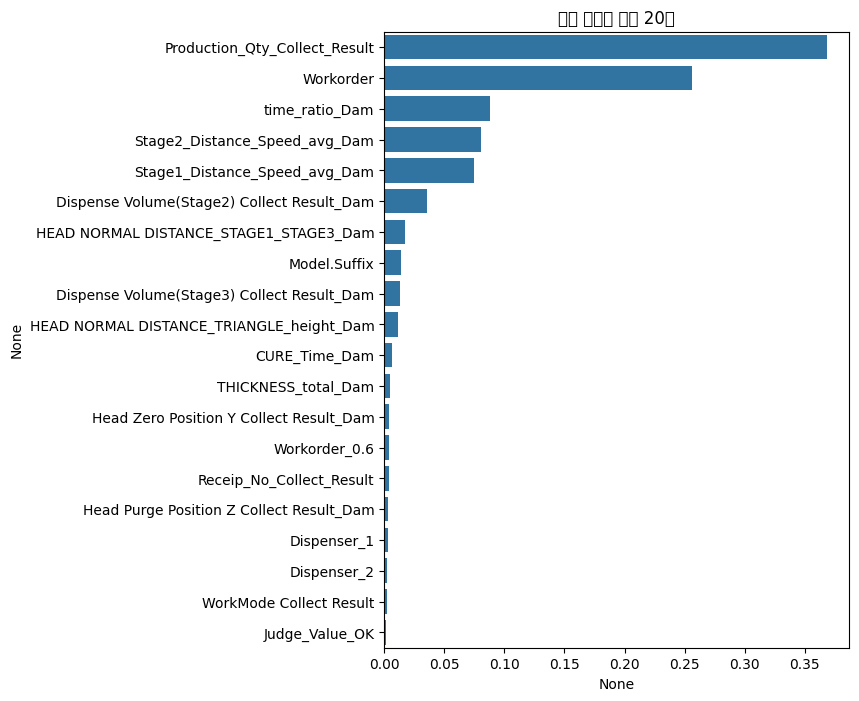

In [114]:
# 랜덤 포레스트 기반 변수 중요도 
feature_imp = model.feature_importances_
feature_imp = pd.Series(feature_imp, index=x_train.columns).sort_values(ascending=False)[:20] #중요도 상위 20개

# 시각화
plt.figure(figsize=(6, 8))
plt.title('변수 중요도 상위 20개')
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.show()